# Análise de Ações da S&P 500: Cotação + Notícias

**Objetivo**  
Dado um ticker de empresa listada na S&P 500, extrair:
1. Nome da empresa  
2. Cotação atual  
3. Últimas _n_ notícias (título e resumo)  

E depois fazer uma análise simples (comprimento dos títulos, frequência de palavras nos resumos).


## Introdução

Neste notebook vamos demonstrar como extrair, de forma totalmente automatizada, 
a cotação atual de qualquer ação da S&P 500 diretamente do Yahoo Finance, 
e em seguida fazer _web-scraping_ das últimas notícias relacionadas a essa empresa, 
também no Yahoo. Finalmente, faremos uma pequena análise exploratória de texto.


In [114]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

## Metodologia

1. Montar URL base do Yahoo Finance:  
   `https://finance.yahoo.com/quote/{ticker}`  
2. Fazer `requests.get` e parsear com BeautifulSoup.  
3. Extrair:
   - **Nome da empresa** no `<h1>` do topo.
   - **Preço atual** no primeiro `<fin-streamer data-field="regularMarketPrice">`.
   - **Notícias**: nos primeiros `<li>` de classe `js-stream-content`, pegar `<h3>` (título) e `<p>` (resumo).
4. Consolidar em um `dict` + `DataFrame`.
5. Análise simples: histogramas e _word cloud_.


In [115]:
def fetch_page(ticker: str) -> BeautifulSoup:
    url = f"https://finance.yahoo.com/quote/{ticker}"
    print(f"→ Fetching URL: {url}")
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")

def get_company_name(soup: BeautifulSoup) -> str:
    h1 = soup.select_one("#quote-header-info h1")
    return h1.text.strip() if h1 else None

# — Cell: extração de preço atual —
def get_current_price(soup):
    # procura a tag que contém o preço
    tag = soup.find("fin-streamer", {"data-field": "regularMarketPrice"})
    if not tag:
        return None
    # remove vírgulas de milhares e faz strip
    txt = tag.text.strip().replace(",", "")
    try:
        return float(txt)
    except ValueError:
        return None


def get_latest_news(ticker: str, n: int = 5) -> pd.DataFrame:
    rss_url = (
        "https://feeds.finance.yahoo.com/rss/2.0/headline"
        f"?s={ticker}&region=US&lang=en-US"
    )
    r = requests.get(rss_url, headers=HEADERS)
    r.raise_for_status()
    xml = BeautifulSoup(r.text, "xml")
    items = xml.find_all("item")[:n]
    dados = []
    for it in items:
        dados.append({
            "titulo":  it.title.text.strip(),
            "resumo":  it.description.text.strip()
        })
    df = pd.DataFrame(dados, columns=["titulo","resumo"])
    return df

def analyze_stock(ticker: str, n_news: int = 5) -> dict:
    soup = fetch_page(ticker)
    return {
        "ticker":      ticker,
        "nome":        get_company_name(soup),
        "preco_atual": get_current_price(soup),
        "noticias":    get_latest_news(ticker, n=n_news)
    }



In [116]:
res = analyze_stock("AAPL", n_news=5)
print(f"{res['nome']} ({res['ticker']}) → Cotação: {res['preco_atual']}")
res["noticias"]


→ Fetching URL: https://finance.yahoo.com/quote/AAPL
None (AAPL) → Cotação: 5706.75


,titulo,resumo
0,Google Stock Had a Bad Week. Why We’re Sticking With Our Alphabet Pick.,Shares plunged on fears of search disruption. That doesn’t mean the company isn’t prepared for change.
1,Latest News In Cloud AI - Multimodal AI Safety Risks and Emerging Security Measures,"A recent report by Enkrypt AI highlights critical safety risks in the rapidly evolving landscape of multimodal AI, which processes both text and images. The findings, derived from red teaming exer..."
2,Google’s search dominance might not be in as much danger as Apple would have you to believe,"Apple says its seen a drop in search queries via its Safari browser, which uses Google Search. But that doesn't mean Google is done for."
3,"What Apple, Amazon, GM And Other Companies Are Saying About Trump Tariffs","Amazon, GM, Apple and other companies are providing some Trump tariffs insight, but ""uncertainty"" remains a common theme."
4,1 Simple Reason That Alphabet Should Be Worth More Than Apple or Microsoft,Alphabet could be bigger than Microsoft or Apple if it had the same premium for its stock. Alphabet's net income is far higher than either of these two. Investors are worried about an economic s...


## Extração para vários tickers

Você pode carregar uma lista de tickers da S&P 500 (ex: CSV oficial) ou usar um subset manual abaixo.

In [117]:
tickers = ["AAPL", "MSFT", "GOOGL"]
todos = [analyze_stock(t, n_news=3) for t in tickers]

df_prices = pd.DataFrame([
    {"ticker": r["ticker"], "nome": r["nome"], "preco_atual": r["preco_atual"]}
    for r in todos
])
df_prices

→ Fetching URL: https://finance.yahoo.com/quote/AAPL
→ Fetching URL: https://finance.yahoo.com/quote/MSFT
→ Fetching URL: https://finance.yahoo.com/quote/GOOGL


,ticker,nome,preco_atual
0,AAPL,None,5706.75
1,MSFT,None,5706.75
2,GOOGL,None,5707.00


## Análise exploratória de texto

Vamos ver o comprimento dos títulos e as palavras mais frequentes nos resumos.


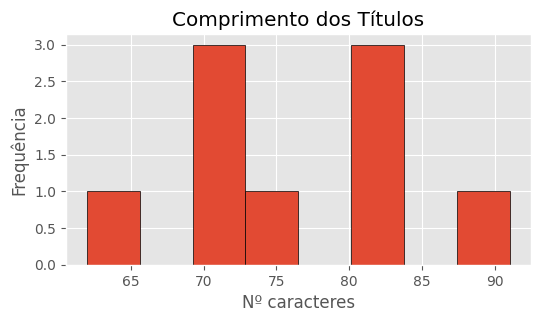

In [118]:
df_news = pd.concat([r["noticias"] for r in todos], ignore_index=True)

# Garante coluna mesmo vazia
if "titulo" not in df_news:
    df_news["titulo"] = []

lengths = df_news["titulo"].str.len()
plt.figure(figsize=(6,3))
plt.hist(lengths.dropna(), bins=8, edgecolor="k")
plt.title("Comprimento dos Títulos")
plt.xlabel("Nº caracteres")
plt.ylabel("Frequência")
plt.show()


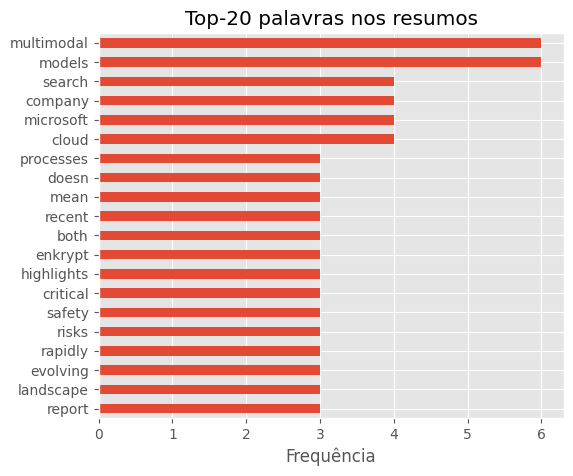

In [119]:
from collections import Counter

text = " ".join(df_news["resumo"].dropna()).lower()
tokens = re.findall(r"[a-zà-ú]{3,}", text)
# — Cell: definição de stop-words —
stop = set([
    # inglês
    "the","for","and","they","a","an","in","to","with","on","of","is",
    "at","that","this","it","by","from","as","be","are","not","or","but",
    "its","has","have","was","were","will","if","can","more","than",
    "about","what","when","who","where","which","why","so","up",
    # português (se ainda quiser filtrar algumas)
    "uma","como","dos","das","este","essa"
])

words  = [w for w in tokens if w not in stop]

freq = Counter(words)
top20 = dict(freq.most_common(20))

plt.figure(figsize=(6,5))
(pd.Series(top20)
   .sort_values()
   .plot.barh())
plt.title("Top-20 palavras nos resumos")
plt.xlabel("Frequência")
plt.show()



## Conclusão

- Extraímos nome, preço e notícias de qualquer ação da S&P 500 usando só requests+BS4.  
- Vimos como histogramas e contagem de palavras dão insight rápido sobre o texto.  
- Em próximos passos, poderíamos adicionar análise de sentimento, séries históricas de preço, etc.
